In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Section 0: Imports and Install 📢**



In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 43.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 71.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [ ]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time


# **Section 1: Load Dataset 📑**

## 1-1: Read Dataset

In [ ]:
# !cp your_dataset_address /content/
!unrar e /content/dataset.rar


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/dataset.rar

Extracting  test .csv                                                     22%  OK 
Extracting  train.csv                                                     99%  OK 
All OK


In [ ]:
df = pd.read_csv('/content/train.csv')
# df.describe()
X = df.drop('DEATH_EVENT', axis=1).values
y = df['DEATH_EVENT'].values
X.shape, y.shape

((249, 12), (249,))

##1-2: Train_Test_Split

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, random_state=42)

##1-3: Preprocess

In [ ]:
# Convert to tensor
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)

X_valid = torch.FloatTensor(X_valid)
y_valid = torch.FloatTensor(y_valid)

# Standardization
mu = torch.mean(X_train, dim=0)
std = torch.std(X_train, dim=0)

X_train = (X_train - mu) / std
X_valid = (X_valid - mu) / std

print(X_train.shape , X_valid.shape)

torch.Size([199, 12]) torch.Size([50, 12])


##1-4: Dataloader

In [ ]:
# Train
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# Validation
valid_dataset = TensorDataset(X_valid, y_valid)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)

#**Section 2: Define Model 🧠**

##2-1: make your MLP Model

In [ ]:
in_features = 12
out_features = 1
h1 = 64
h2 = 32

model = nn.Sequential(nn.Linear(in_features, h1),
                      nn.ReLU(),
                      nn.Linear(h1, h2),
                      nn.ReLU(),
                      nn.Linear(h2, out_features),
                      nn.Sigmoid())
model

Sequential(
  (0): Linear(in_features=12, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=1, bias=True)
  (5): Sigmoid()
)

##2-2: Loss and Optimizer

In [ ]:
# Define the loss function and optimizer

# Loss function
loss_fn = nn.BCELoss()

# Optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001)


##2-3: Bias for last layer(before train)

In [ ]:
bias_last = model[-2].bias
bias_last

Parameter containing:
tensor([-0.3946], device='cuda:0', requires_grad=True)

#**Section 3: Device ⚙️**

In [ ]:
# Define device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

!nvidia-smi
print(torch.cuda.get_device_name())


#**Section 4: Train Model 🤓**

##4-1: Utils

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

##4-1: Torchmetrics

In [ ]:
from torchmetrics import Accuracy

##4-2: Train Loop

In [ ]:
loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

In [ ]:
num_epochs = 500


start_time = time.time()
for epoch in range(num_epochs):
  loss_train = AverageMeter()
  acc_train = Accuracy(task = 'binary').to(device)
  for i, (inputs, targets) in enumerate(train_loader):
    inputs = inputs.to(device)
    targets = targets.to(device)

    outputs = model(inputs)
    loss = loss_fn(outputs.squeeze(), targets)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    loss_train.update(loss.item(),len(targets))
    acc_train(outputs.squeeze(), targets.int())

  loss_train_hist.append(loss_train.avg)
  acc_train_hist.append(acc_train.compute().cpu())
  with torch.no_grad():
    loss_valid = AverageMeter()
    acc_valid = Accuracy(task='binary').to(device)
    for i, (inputs, targets) in enumerate(valid_loader):
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs.squeeze(), targets)

      loss_valid.update(loss.item(),len(targets))
      acc_valid(outputs.squeeze(), targets.int())

  loss_valid_hist.append(loss_valid.avg)
  acc_valid_hist.append(acc_valid.compute().cpu())

  if epoch % 10 ==0:

    print(f'Epoch: {epoch}')
    print(f'\tTrain Loss: {loss_train.avg:.4f} | Train Accuracy: {acc_train.compute():.4f}')
    print(f'\tValidation Loss: {loss_valid.avg:.4f} | Validation Accuracy: {acc_valid.compute():.4f} \n')

end_time = time.time() - start_time
print(f'Train Time: {end_time}')



Epoch: 0
	Train Loss: 0.7115 | Train Accuracy: 0.3065
	Validation Loss: 0.7189 | Validation Accuracy: 0.3400 

Epoch: 10
	Train Loss: 0.6980 | Train Accuracy: 0.4623
	Validation Loss: 0.7051 | Validation Accuracy: 0.4000 

Epoch: 20
	Train Loss: 0.6861 | Train Accuracy: 0.6080
	Validation Loss: 0.6927 | Validation Accuracy: 0.5000 

Epoch: 30
	Train Loss: 0.6754 | Train Accuracy: 0.6633
	Validation Loss: 0.6815 | Validation Accuracy: 0.6200 

Epoch: 40
	Train Loss: 0.6657 | Train Accuracy: 0.7085
	Validation Loss: 0.6715 | Validation Accuracy: 0.6600 

Epoch: 50
	Train Loss: 0.6573 | Train Accuracy: 0.6985
	Validation Loss: 0.6627 | Validation Accuracy: 0.6800 

Epoch: 60
	Train Loss: 0.6498 | Train Accuracy: 0.7035
	Validation Loss: 0.6550 | Validation Accuracy: 0.6800 

Epoch: 70
	Train Loss: 0.6429 | Train Accuracy: 0.6935
	Validation Loss: 0.6477 | Validation Accuracy: 0.7000 

Epoch: 80
	Train Loss: 0.6368 | Train Accuracy: 0.6884
	Validation Loss: 0.6413 | Validation Accuracy: 0.

#**Section 5: Result 📈**

##5-1: Plot loss and acc

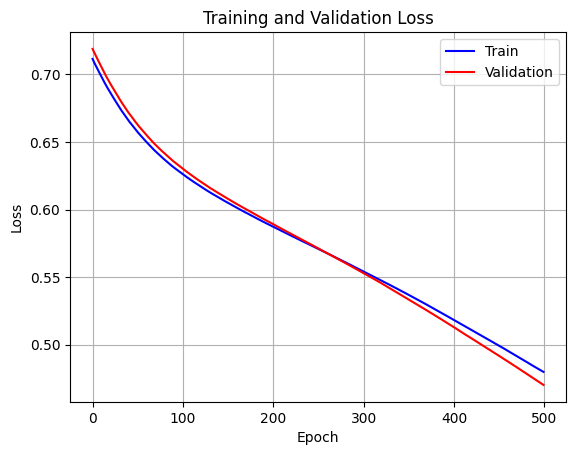

In [ ]:
plt.plot(range(num_epochs), loss_train_hist, 'b-', label="Train")
plt.plot(range(num_epochs), loss_valid_hist, 'r-', label="Validation")

plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

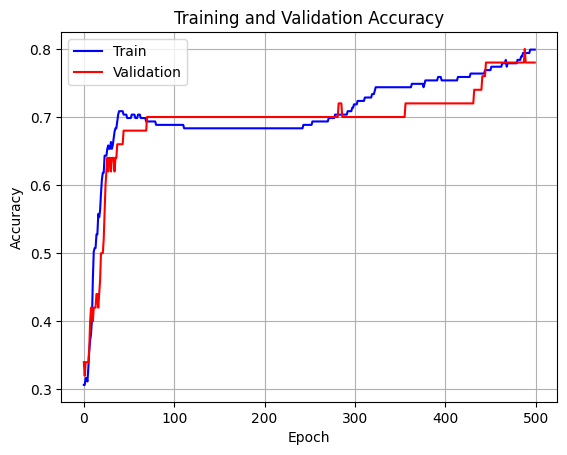

In [ ]:
# plot acc_epoch
plt.plot(range(num_epochs), acc_train_hist, 'b-', label="Train")
plt.plot(range(num_epochs), acc_valid_hist, 'r-', label="Validation")

plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

##5-2: Count param

In [ ]:
num_params = torch.tensor([torch.numel(param) for param in model.parameters()]).sum()
num_params

tensor(2945)

##5-3: Bias for last layer(after train)

In [ ]:
bias_last = list(model.state_dict().values())[-1]
bias_last

tensor([-0.1007], device='cuda:0')

#**Section 6: Save and Load Model 💰**

##6-1: Save

In [ ]:
torch.save(model, '/content/model.pt')

##6-2: Load

In [ ]:
torch.load('/content/model.pt')

Sequential(
  (0): Linear(in_features=12, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=1, bias=True)
  (5): Sigmoid()
)

#**Section 7: Model Prediction👀**

##7-1: Use test.csv

In [ ]:
df_test = pd.read_csv('/content/test .csv')
X_test = df_test.values

# Convert to tensor
X_test = torch.FloatTensor(X_test)

# Standardization
X_test = (X_test - mu) / std
X_test.shape

torch.Size([49, 12])

##7-2: Make predictions.csv file

In [ ]:
# Compute predicted outputs
test_preds = []

# Load the model
model = torch.load('/content/model.pt')
model = model.to(device)
with torch.no_grad():
  for inputs in X_test:
    inputs = inputs.to(device)
    test_pred = model(inputs)
    test_preds.append(test_pred.round().item())

# Save Prediction to CSV file
header_list = ['pred']
pd.DataFrame(test_preds).to_csv('/content/predictions.csv', header=header_list, index=False)

# predict = pd.read_csv('/content/predictions.csv')
# predict.head()


In [ ]:
import numpy as np
main_test = pd.read_csv('/content/full_test_homework_3.csv')
print(main_test.shape)
target_test = main_test['DEATH_EVENT'].values
print(target_test.shape)
pred_va = pd.read_csv('/content/predictions.csv')
pred_test = pred_va['pred'].values
print(pred_test.shape)
acc_test = 100. * np.sum(target_test == pred_test)/len(pred_test)
print(acc_test)

(49, 13)
(49,)
(49,)
63.265306122448976


#**Section 8: Hyperparam 🔨**

##8-1: Change hyperparam

Plot loss_epoch for batch_size: 4, 8, 16

Epoch: 0
	Train Loss: 0.6764 | Train Accuracy: 0.6683%
	Validation Loss: 0.6718 | Validation Accuracy: 0.7000%

Epoch: 10
	Train Loss: 0.6608 | Train Accuracy: 0.6834%
	Validation Loss: 0.6549 | Validation Accuracy: 0.7000%

Epoch: 20
	Train Loss: 0.6497 | Train Accuracy: 0.6834%
	Validation Loss: 0.6426 | Validation Accuracy: 0.7000%

Epoch: 30
	Train Loss: 0.6411 | Train Accuracy: 0.6834%
	Validation Loss: 0.6329 | Validation Accuracy: 0.7000%

Epoch: 40
	Train Loss: 0.6339 | Train Accuracy: 0.6834%
	Validation Loss: 0.6246 | Validation Accuracy: 0.7000%

Epoch: 50
	Train Loss: 0.6275 | Train Accuracy: 0.6834%
	Validation Loss: 0.6173 | Validation Accuracy: 0.7000%

Epoch: 60
	Train Loss: 0.6214 | Train Accuracy: 0.6834%
	Validation Loss: 0.6103 | Validation Accuracy: 0.7000%

Epoch: 70
	Train Loss: 0.6153 | Train Accuracy: 0.6834%
	Validation Loss: 0.6031 | Validation Accuracy: 0.7000%

Epoch: 80
	Train Loss: 0.6089 | Train Accuracy: 0.6834%
	Validation Loss: 0.5956 | Validation Acc

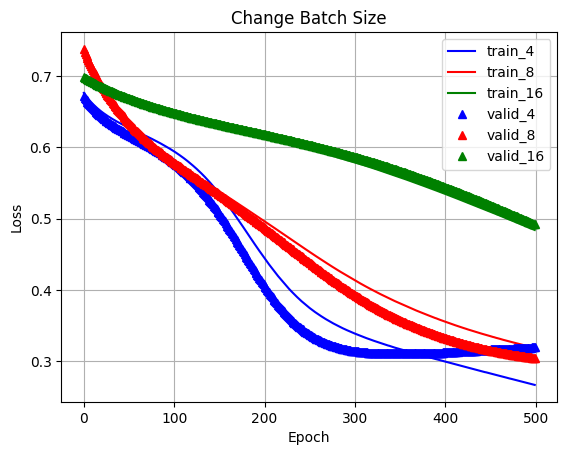

In [ ]:
loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

# Compute loss by changing bact size
for batch_size in [4, 8, 16]:

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

  model = nn.Sequential(nn.Linear(in_features, h1),
                        nn.ReLU(),
                        nn.Linear(h1, h2),
                        nn.ReLU(),
                        nn.Linear(h2, out_features),
                        nn.Sigmoid())

  model = model.to(device)

  optimizer = optim.SGD(model.parameters(), lr=0.001)

  for epoch in range(num_epochs):

    loss_train = AverageMeter()
    acc_train = Accuracy(task = 'binary').to(device)
    for i, (inputs, targets) in enumerate(train_loader):
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs.squeeze(), targets)

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(),len(targets))
      acc_train(outputs.squeeze(), targets.int())

    loss_train_hist.append(loss_train.avg)
    acc_train_hist.append(acc_train.compute().cpu())
    with torch.no_grad():
      loss_valid = AverageMeter()
      acc_valid = Accuracy(task='binary').to(device)
      for i, (inputs, targets) in enumerate(valid_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)
        loss = loss_fn(outputs.squeeze(), targets)

        loss_valid.update(loss.item(),len(targets))
        acc_valid(outputs.squeeze(), targets.int())

    loss_valid_hist.append(loss_valid.avg)
    acc_valid_hist.append(acc_valid.compute().cpu())

    if epoch % 10 ==0:

      print(f'Epoch: {epoch}')
      print(f'\tTrain Loss: {loss_train.avg:.4f} | Train Accuracy: {acc_train.compute():.4f}%')
      print(f'\tValidation Loss: {loss_valid.avg:.4f} | Validation Accuracy: {acc_valid.compute():.4f}%\n')


#******************************************************************************#
# plot loss_epoch
plt.plot(range(num_epochs), loss_train_hist[0:num_epochs], '-b', label="train_4")
plt.plot(range(num_epochs), loss_train_hist[num_epochs:2 * num_epochs], '-r', label="train_8")
plt.plot(range(num_epochs), loss_train_hist[2 * num_epochs:3 * num_epochs], '-g', label="train_16")


plt.plot(range(num_epochs), loss_valid_hist[0:num_epochs], '^b', label="valid_4")
plt.plot(range(num_epochs), loss_valid_hist[num_epochs:2 * num_epochs], '^r', label="valid_8")
plt.plot(range(num_epochs), loss_valid_hist[2 * num_epochs:3 * num_epochs], '^g', label="valid_16")

plt.title("Change Batch Size")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()



Plot loss_epoch for learning rate: 0.1, 0.01, 0.001







Epoch: 0
	Train Loss: 0.6672 | Train Accuracy: 0.6382%
	Validation Loss: 0.6199 | Validation Accuracy: 0.7000%

Epoch: 10
	Train Loss: 0.3318 | Train Accuracy: 0.8844%
	Validation Loss: 0.3063 | Validation Accuracy: 0.8800%

Epoch: 20
	Train Loss: 0.2449 | Train Accuracy: 0.9095%
	Validation Loss: 0.3220 | Validation Accuracy: 0.8600%

Epoch: 30
	Train Loss: 0.1616 | Train Accuracy: 0.9447%
	Validation Loss: 0.4164 | Validation Accuracy: 0.8600%

Epoch: 40
	Train Loss: 0.0989 | Train Accuracy: 0.9799%
	Validation Loss: 0.4921 | Validation Accuracy: 0.8400%

Epoch: 50
	Train Loss: 0.0612 | Train Accuracy: 0.9849%
	Validation Loss: 0.6612 | Validation Accuracy: 0.8400%

Epoch: 60
	Train Loss: 0.0382 | Train Accuracy: 0.9950%
	Validation Loss: 0.7076 | Validation Accuracy: 0.8400%

Epoch: 70
	Train Loss: 0.0279 | Train Accuracy: 0.9899%
	Validation Loss: 0.8115 | Validation Accuracy: 0.8400%

Epoch: 80
	Train Loss: 0.0195 | Train Accuracy: 0.9950%
	Validation Loss: 0.8121 | Validation Acc

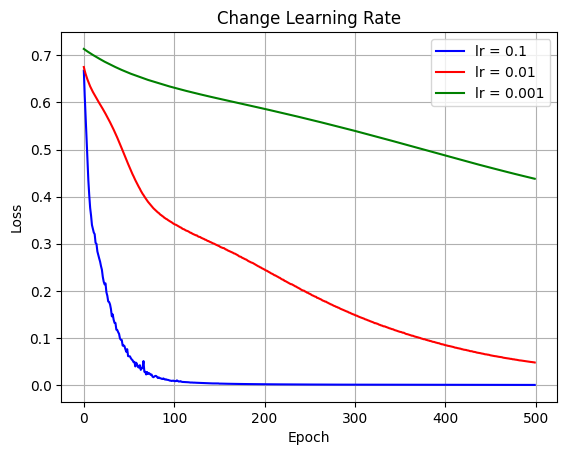

In [ ]:
loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

for learning_rate in [0.1, 0.01, 0.001]:
  model = nn.Sequential(nn.Linear(in_features, h1),
                    nn.ReLU(),
                    nn.Linear(h1, h2),
                    nn.ReLU(),
                    nn.Linear(h2, out_features),
                    nn.Sigmoid())
  model = model.to(device)
  optimizer = optim.SGD(model.parameters(), lr=learning_rate)

  for epoch in range(num_epochs):
    loss_train = AverageMeter()
    acc_train = Accuracy(task = 'binary').to(device)
    for i, (inputs, targets) in enumerate(train_loader):
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs.squeeze(), targets)

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(),len(targets))
      acc_train(outputs.squeeze(), targets.int())

    loss_train_hist.append(loss_train.avg)
    acc_train_hist.append(acc_train.compute().cpu())
    with torch.no_grad():
      loss_valid = AverageMeter()
      acc_valid = Accuracy(task='binary').to(device)
      for i, (inputs, targets) in enumerate(valid_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)
        loss = loss_fn(outputs.squeeze(), targets)

        loss_valid.update(loss.item(),len(targets))
        acc_valid(outputs.squeeze(), targets.int())

    loss_valid_hist.append(loss_valid.avg)
    acc_valid_hist.append(acc_valid.compute().cpu())

    if epoch % 10 ==0:

      print(f'Epoch: {epoch}')
      print(f'\tTrain Loss: {loss_train.avg:.4f} | Train Accuracy: {acc_train.compute():.4f}%')
      print(f'\tValidation Loss: {loss_valid.avg:.4f} | Validation Accuracy: {acc_valid.compute():.4f}%\n')

#******************************************************************************#
# plot loss_epoch
plt.plot(range(num_epochs), loss_train_hist[0:num_epochs], '-b', label="lr = 0.1")
plt.plot(range(num_epochs), loss_train_hist[num_epochs : 2 * num_epochs], '-r', label="lr = 0.01")
plt.plot(range(num_epochs), loss_train_hist[2 * num_epochs : 3 * num_epochs], '-g', label="lr = 0.001")



plt.title("Change Learning Rate")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()


Plot loss_epoch for layer: 2, 3, 4

Epoch: 0
	Train Loss: 0.6813 | Train Accuracy: 0.7085%
	Validation Loss: 0.6829 | Validation Accuracy: 0.7000%

Epoch: 10
	Train Loss: 0.6758 | Train Accuracy: 0.7085%
	Validation Loss: 0.6770 | Validation Accuracy: 0.7200%

Epoch: 20
	Train Loss: 0.6707 | Train Accuracy: 0.6985%
	Validation Loss: 0.6715 | Validation Accuracy: 0.7000%

Epoch: 30
	Train Loss: 0.6659 | Train Accuracy: 0.6884%
	Validation Loss: 0.6663 | Validation Accuracy: 0.7000%

Epoch: 40
	Train Loss: 0.6613 | Train Accuracy: 0.6935%
	Validation Loss: 0.6613 | Validation Accuracy: 0.7000%

Epoch: 50
	Train Loss: 0.6569 | Train Accuracy: 0.6884%
	Validation Loss: 0.6567 | Validation Accuracy: 0.7000%

Epoch: 60
	Train Loss: 0.6528 | Train Accuracy: 0.6884%
	Validation Loss: 0.6523 | Validation Accuracy: 0.7000%

Epoch: 70
	Train Loss: 0.6488 | Train Accuracy: 0.6834%
	Validation Loss: 0.6480 | Validation Accuracy: 0.7000%

Epoch: 80
	Train Loss: 0.6449 | Train Accuracy: 0.6834%
	Validation Loss: 0.6438 | Validation Acc

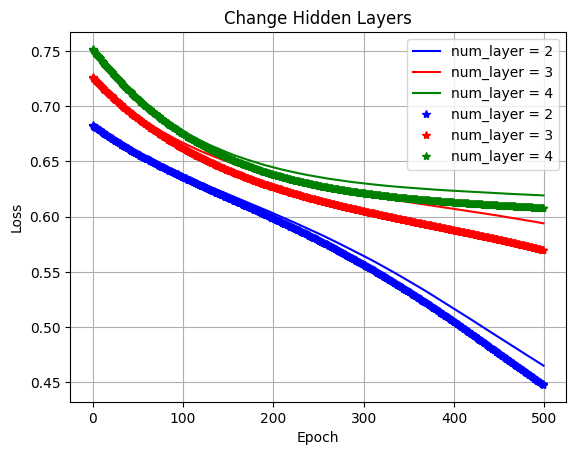

In [ ]:
def multi_layer_model(num_layer):
  """Initialize mlp model with different layers"""
  in_features = 12
  out_features = 1
  h1 = 64
  h2 = 32
  h3 = 16
  h4 = 8

  if num_layer == 2:
    model = nn.Sequential(nn.Linear(in_features, h1),
                          nn.ReLU(),
                          nn.Linear(h1, h2),
                          nn.ReLU(),
                          nn.Linear(h2, out_features),
                          nn.Sigmoid())
    return model

  elif num_layer == 3:
    model = nn.Sequential(nn.Linear(in_features, h1),
                          nn.ReLU(),
                          nn.Linear(h1, h2),
                          nn.ReLU(),
                          nn.Linear(h2, h3),
                          nn.ReLU(),
                          nn.Linear(h3, out_features),
                          nn.Sigmoid())
    return model

  elif num_layer == 4:
    model = nn.Sequential(nn.Linear(in_features, h1),
                          nn.ReLU(),
                          nn.Linear(h1, h2),
                          nn.ReLU(),
                          nn.Linear(h2, h3),
                          nn.ReLU(),
                          nn.Linear(h3, h4),
                          nn.ReLU(),
                          nn.Linear(h4, out_features),
                          nn.Sigmoid())
    return model

#******************************************************************************#
loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

# compute loss by changing number of layer
for num_layer in [2, 3, 4]:
  model = multi_layer_model(num_layer)
  model = model.to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.001)

  for epoch in range(num_epochs):
    loss_train = AverageMeter()
    acc_train = Accuracy(task = 'binary').to(device)
    for i, (inputs, targets) in enumerate(train_loader):
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs.squeeze(), targets)

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(),len(targets))
      acc_train(outputs.squeeze(), targets.int())

    loss_train_hist.append(loss_train.avg)
    acc_train_hist.append(acc_train.compute().cpu())
    with torch.no_grad():
      loss_valid = AverageMeter()
      acc_valid = Accuracy(task='binary').to(device)
      for i, (inputs, targets) in enumerate(valid_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)
        loss = loss_fn(outputs.squeeze(), targets)

        loss_valid.update(loss.item(),len(targets))
        acc_valid(outputs.squeeze(), targets.int())

    loss_valid_hist.append(loss_valid.avg)
    acc_valid_hist.append(acc_valid.compute().cpu())

    if epoch % 10 ==0:

      print(f'Epoch: {epoch}')
      print(f'\tTrain Loss: {loss_train.avg:.4f} | Train Accuracy: {acc_train.compute():.4f}%')
      print(f'\tValidation Loss: {loss_valid.avg:.4f} | Validation Accuracy: {acc_valid.compute():.4f}%\n')

#******************************************************************************#
# plot loss_epoch
plt.plot(range(num_epochs), loss_train_hist[0:num_epochs], '-b', label="num_layer = 2")
plt.plot(range(num_epochs), loss_train_hist[num_epochs:2 * num_epochs], '-r', label="num_layer = 3")
plt.plot(range(num_epochs), loss_train_hist[2 * num_epochs:3 * num_epochs], '-g', label="num_layer = 4")

plt.plot(range(num_epochs), loss_valid_hist[0:num_epochs], '*b', label="num_layer = 2")
plt.plot(range(num_epochs), loss_valid_hist[num_epochs:2 * num_epochs], '*r', label="num_layer = 3")
plt.plot(range(num_epochs), loss_valid_hist[2 * num_epochs:3 * num_epochs], '*g', label="num_layer = 4")

plt.title("Change Hidden Layers")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()


##8-2: Calculate time

Train with CPU

In [ ]:
# Transfer to CPU
device = 'cpu'
model = nn.Sequential(nn.Linear(in_features, h1),
                    nn.ReLU(),
                    nn.Linear(h1, h2),
                    nn.ReLU(),
                    nn.Linear(h2, out_features),
                    nn.Sigmoid())
model = model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.001)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

num_epochs = 500

loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []


start_time = time.time()
for epoch in range(num_epochs):
  loss_train = AverageMeter()
  acc_train = Accuracy(task = 'binary').to(device)
  for i, (inputs, targets) in enumerate(train_loader):
    inputs = inputs.to(device)
    targets = targets.to(device)

    outputs = model(inputs)
    loss = loss_fn(outputs.squeeze(), targets)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    loss_train.update(loss.item(),len(targets))
    acc_train(outputs.squeeze(), targets.int())

  loss_train_hist.append(loss_train.avg)
  acc_train_hist.append(acc_train.compute().cpu())
  with torch.no_grad():
    loss_valid = AverageMeter()
    acc_valid = Accuracy(task='binary').to(device)
    for i, (inputs, targets) in enumerate(valid_loader):
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs.squeeze(), targets)

      loss_valid.update(loss.item(),len(targets))
      acc_valid(outputs.squeeze(), targets.int())

  loss_valid_hist.append(loss_valid.avg)
  acc_valid_hist.append(acc_valid.compute().cpu())

  if epoch % 10 ==0:

    print(f'Epoch: {epoch}')
    print(f'\tTrain Loss: {loss_train.avg:.4f} | Train Accuracy: {acc_train.compute():.4f}%')
    print(f'\tValidation Loss: {loss_valid.avg:.4f} | Validation Accuracy: {acc_valid.compute():.4f}%\n')

end_time = time.time() - start_time
print(f'Train Time: {end_time}')


Epoch: 0
	Train Loss: 0.7031 | Train Accuracy: 0.3618%
	Validation Loss: 0.6988 | Validation Accuracy: 0.5200%

Epoch: 10
	Train Loss: 0.6693 | Train Accuracy: 0.6834%
	Validation Loss: 0.6640 | Validation Accuracy: 0.7000%

Epoch: 20
	Train Loss: 0.6454 | Train Accuracy: 0.6834%
	Validation Loss: 0.6389 | Validation Accuracy: 0.7000%

Epoch: 30
	Train Loss: 0.6271 | Train Accuracy: 0.6834%
	Validation Loss: 0.6194 | Validation Accuracy: 0.7000%

Epoch: 40
	Train Loss: 0.6121 | Train Accuracy: 0.6834%
	Validation Loss: 0.6036 | Validation Accuracy: 0.7000%

Epoch: 50
	Train Loss: 0.5990 | Train Accuracy: 0.6834%
	Validation Loss: 0.5896 | Validation Accuracy: 0.7000%

Epoch: 60
	Train Loss: 0.5869 | Train Accuracy: 0.6834%
	Validation Loss: 0.5769 | Validation Accuracy: 0.7000%

Epoch: 70
	Train Loss: 0.5753 | Train Accuracy: 0.6834%
	Validation Loss: 0.5645 | Validation Accuracy: 0.7000%

Epoch: 80
	Train Loss: 0.5635 | Train Accuracy: 0.6834%
	Validation Loss: 0.5518 | Validation Acc

##8-3: Activation Function

Plot acc_epoch for LeakyReLU and GeLU

Epoch: 0
	Train Loss: 0.7225 | Train Accuracy: 0.3216%
	Validation Loss: 0.7130 | Validation Accuracy: 0.3000%

Epoch: 10
	Train Loss: 0.6822 | Train Accuracy: 0.6181%
	Validation Loss: 0.6697 | Validation Accuracy: 0.7000%

Epoch: 20
	Train Loss: 0.6544 | Train Accuracy: 0.7186%
	Validation Loss: 0.6383 | Validation Accuracy: 0.7400%

Epoch: 30
	Train Loss: 0.6333 | Train Accuracy: 0.7085%
	Validation Loss: 0.6139 | Validation Accuracy: 0.7200%

Epoch: 40
	Train Loss: 0.6159 | Train Accuracy: 0.6985%
	Validation Loss: 0.5935 | Validation Accuracy: 0.7200%

Epoch: 50
	Train Loss: 0.6004 | Train Accuracy: 0.6985%
	Validation Loss: 0.5751 | Validation Accuracy: 0.7200%

Epoch: 60
	Train Loss: 0.5854 | Train Accuracy: 0.7035%
	Validation Loss: 0.5571 | Validation Accuracy: 0.7200%

Epoch: 70
	Train Loss: 0.5699 | Train Accuracy: 0.7085%
	Validation Loss: 0.5389 | Validation Accuracy: 0.7200%

Epoch: 80
	Train Loss: 0.5537 | Train Accuracy: 0.7085%
	Validation Loss: 0.5200 | Validation Acc

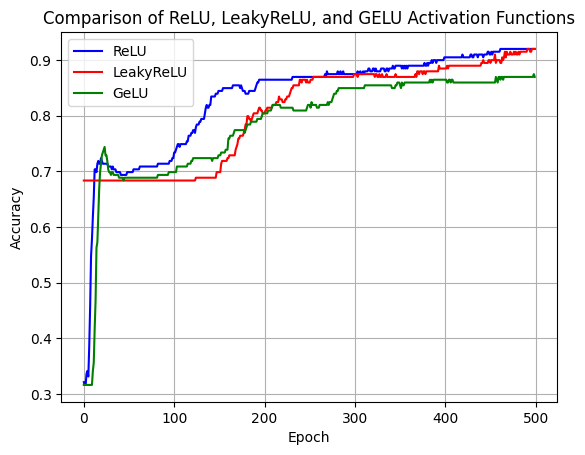

In [ ]:
in_features = 12
out_features = 1
h1 = 64
h2 = 32

# model with ReLU activation function
def mlp_model_relu():
  model = nn.Sequential(nn.Linear(in_features, h1),
                        nn.ReLU(),
                        nn.Linear(h1, h2),
                        nn.ReLU(),
                        nn.Linear(h2, out_features),
                        nn.Sigmoid())
  return model

#******************************************************************************#
# model with LeakyReLU activation function
def mlp_model_leaky_relu():
  model = nn.Sequential(nn.Linear(in_features, h1),
                        nn.LeakyReLU(),
                        nn.Linear(h1, h2),
                        nn.LeakyReLU(),
                        nn.Linear(h2, out_features),
                        nn.Sigmoid())
  return model

#******************************************************************************#
# model with GeLU activation function
def mlp_model_gelu():
  model = nn.Sequential(nn.Linear(in_features, h1),
                        nn.GELU(),
                        nn.Linear(h1, h2),
                        nn.GELU(),
                        nn.Linear(h2, out_features),
                        nn.Sigmoid())
  return model

#******************************************************************************#
# Comparison of activation functions
loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

for model in [mlp_model_relu(), mlp_model_leaky_relu(), mlp_model_gelu()]:
  model = model.to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.001)

  num_epochs = 500

  start_time = time.time()
  for epoch in range(num_epochs):
    loss_train = AverageMeter()
    acc_train = Accuracy(task = 'binary').to(device)
    for i, (inputs, targets) in enumerate(train_loader):
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs.squeeze(), targets)

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(),len(targets))
      acc_train(outputs.squeeze(), targets.int())

    loss_train_hist.append(loss_train.avg)
    acc_train_hist.append(acc_train.compute().cpu())
    with torch.no_grad():
      loss_valid = AverageMeter()
      acc_valid = Accuracy(task='binary').to(device)
      for i, (inputs, targets) in enumerate(valid_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)
        loss = loss_fn(outputs.squeeze(), targets)

        loss_valid.update(loss.item(),len(targets))
        acc_valid(outputs.squeeze(), targets.int())

    loss_valid_hist.append(loss_valid.avg)
    acc_valid_hist.append(acc_valid.compute().cpu())

    if epoch % 10 ==0:

      print(f'Epoch: {epoch}')
      print(f'\tTrain Loss: {loss_train.avg:.4f} | Train Accuracy: {acc_train.compute():.4f}%')
      print(f'\tValidation Loss: {loss_valid.avg:.4f} | Validation Accuracy: {acc_valid.compute():.4f}%\n')



#******************************************************************************#
# plot loss_epoch
plt.plot(range(num_epochs), acc_train_hist[0:num_epochs], '-b', label="ReLU")
plt.plot(range(num_epochs), acc_train_hist[num_epochs:2 * num_epochs], '-r', label="LeakyReLU")
plt.plot(range(num_epochs), acc_train_hist[2 * num_epochs:3 * num_epochs], '-g', label="GeLU")

plt.title("Comparison of ReLU, LeakyReLU, and GELU Activation Functions")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()